In [1]:
import paddle
import time
import paddle.nn as nn
import paddle.nn.functional as F
import paddle.vision.transforms as transforms
from paddle.io import DataLoader
import numpy as np
import paddle.optimizer.lr as lrScheduler
from paddle.vision.transforms import BaseTransform
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os

paddle.seed(1024)
np.random.seed(1234)

print(paddle.__version__)


C:\Users\86173\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


3.0.0-rc1


In [21]:
paddle.device.is_compiled_with_cuda()

True

In [22]:
paddle.vision.datasets??

Type:        module
String form: <module 'paddle.vision.datasets' from 'C:\\Users\\86173\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\paddle\\vision\\datasets\\__init__.py'>
File:        c:\users\86173\appdata\local\programs\python\python39\lib\site-packages\paddle\vision\datasets\__init__.py
Source:     
#   Copyright (c) 2020 PaddlePaddle Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from .cifar import Cifar10, Cifar100
from .flowers import Fl

In [18]:
class AutoTransforms(BaseTransform):
    def __init__(self, transforms=None, keys=None):
        super(AutoTransforms, self).__init__(keys)
        self.transforms = transforms

    def _apply_image(self, image):
        if self.transforms is None:
            return image
        choose = np.random.randint(0, len(self.transforms))
        return self.transforms[choose](image)


# 训练集数据增强
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

transforms_list = [
    transforms.BrightnessTransform(0.5),
    transforms.SaturationTransform(0.5),
    transforms.ContrastTransform(0.5),
    transforms.HueTransform(0.5),
    transforms.RandomRotation(15, expand=True, fill=128),
    transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
    transforms.Grayscale(3),
]

train_tx = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        AutoTransforms(transforms_list),
        transforms.RandomCrop(32),
        transforms.RandomVerticalFlip(),
        transforms.Transpose(),
        transforms.Normalize(0.0, 255.0),
        transforms.Normalize(mean, std),
    ]
)

val_tx = transforms.Compose(
    [
        transforms.Transpose(),
        transforms.Normalize(0.0, 255.0),
        transforms.Normalize(mean, std),
    ]
)

cifar100_train = paddle.vision.datasets.Cifar10(
    mode="train", transform=train_tx, download=True
)
cifar100_test = paddle.vision.datasets.Cifar10(
    mode="test", transform=val_tx, download=True
)

print(
    "训练集数量:",
    len(cifar100_train),
    "训练集图像尺寸",
    cifar100_train[0][0].shape,
)
print(
    "测试集数量:",
    len(cifar100_test),
    "测试集图像尺寸",
    cifar100_test[0][0].shape,
)


训练集数量: 50000 训练集图像尺寸 (3, 32, 32)
测试集数量: 10000 测试集图像尺寸 (3, 32, 32)


In [29]:
def anti_normalize(image):
    image = paddle.to_tensor(image)
    t_mean = paddle.to_tensor(mean).reshape([3, 1, 1]).expand([3, 32, 32])
    t_std = paddle.to_tensor(std).reshape([3, 1, 1]).expand([3, 32, 32])
    return (image * t_std + t_mean).transpose([1, 2, 0])


def plot_num_images(num, data):
    if num < 1:
        print("INFO:The number of input pictures must be greater than zero!")
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(data))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for i in range(num):
            ax_img = plt.subplot(
                math.ceil(num / int(math.sqrt(num))), int(math.sqrt(num)), i + 1
            )
            single_data = data[choose_list[i]]
            plt_img = anti_normalize(single_data[0])
            ax_img.imshow(plt_img, cmap="binary")
            ax_img.set_title("label:" + str(single_data[1]), fontsize=10)
            ax_img.axis("off")
        plt.show()


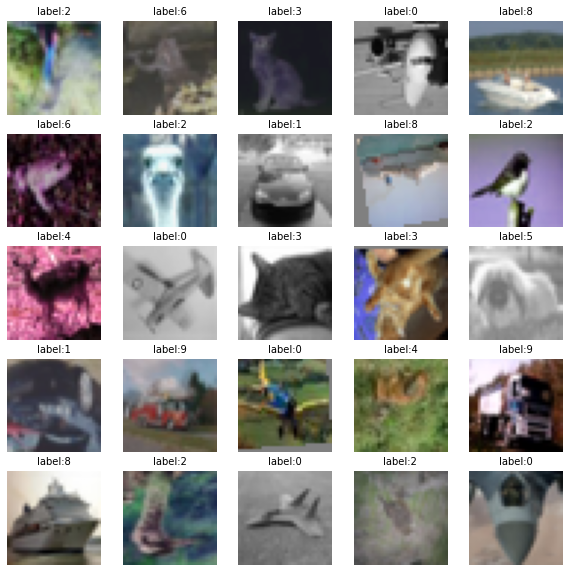

In [30]:
plot_num_images(25, cifar10_train)

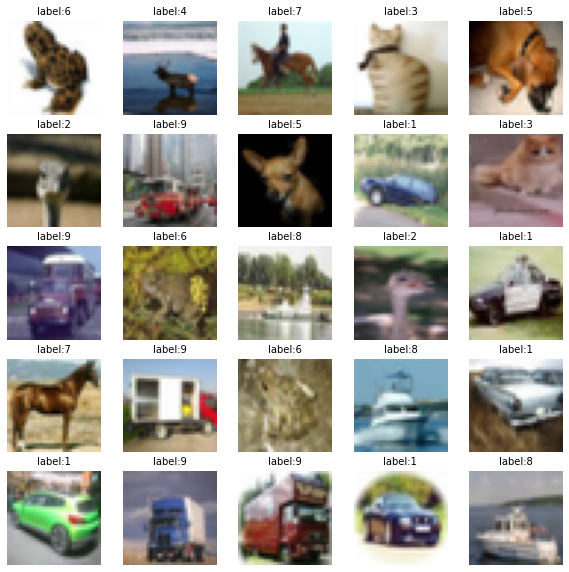

In [31]:
plot_num_images(25, cifar100_test)

In [32]:
class Patches(paddle.nn.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        patches = F.unfold(images, self.patch_size, self.patch_size)
        return patches.transpose([0, 2, 1])


Image size: 32 X 32
Patch size: 8 X 8
Patches per image: 16
Elements per patch: 192


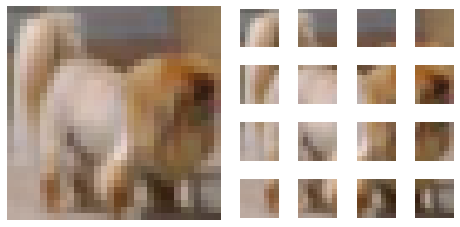

In [33]:
image_size = 32
patch_size = 8

image = anti_normalize(
    paddle.to_tensor(cifar100_test[np.random.choice(len(cifar100_test))][0])
)
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(4, 8, wspace=0.5, figure=fig)
plt.subplot(grid[:4, :4])
plt.imshow(image)
plt.axis("off")

patches = Patches(patch_size)(image.transpose([2, 0, 1]).unsqueeze(0))

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

for i, patch in enumerate(patches[0]):
    plt.subplot(grid[i // 4, i % 4 + 4])
    patch_img = patch.reshape([3, patch_size, patch_size]).transpose([1, 2, 0])
    plt.imshow(patch_img)
    plt.axis("off")


In [34]:
class Mlp(nn.Layer):
    def __init__(self, feats, mlp_hidden, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(feats, mlp_hidden)
        self.fc2 = nn.Linear(mlp_hidden, feats)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)

        return x


In [35]:
class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, feats, head=8, dropout=0.0, attn_dropout=0.0):
        super(MultiHeadSelfAttention, self).__init__()
        self.head = head
        self.feats = feats
        self.sqrt_d = self.feats**0.5
        self.qkv = nn.Linear(feats, feats * 3)
        self.out = nn.Linear(feats, feats)
        self.dropout = nn.Dropout(dropout)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def transpose_multi_head(self, x):
        new_shape = x.shape[:-1] + [self.head, self.feats // self.head]
        x = x.reshape(new_shape)
        x = x.transpose([0, 2, 1, 3])
        return x

    def forward(self, x):
        b, n, f = x.shape
        qkv = self.qkv(x).chunk(3, -1)
        q, k, v = map(self.transpose_multi_head, qkv)
        attn = F.softmax(
            paddle.einsum("bhif, bhjf->bhij", q, k) / self.sqrt_d, axis=-1
        )
        attn = self.attn_dropout(attn)
        attn = paddle.einsum("bhij, bhjf->bihf", attn, v)
        out = self.dropout(self.out(attn.flatten(2)))
        return out


In [36]:
class TransformerEncoder(nn.Layer):
    def __init__(
        self, feats, mlp_hidden, head=8, dropout=0.0, attn_dropout=0.0
    ):
        super(TransformerEncoder, self).__init__()
        self.layer1 = nn.LayerNorm(feats)
        self.msa = MultiHeadSelfAttention(
            feats, head=head, dropout=dropout, attn_dropout=attn_dropout
        )
        self.layer2 = nn.LayerNorm(feats)
        self.mlp = Mlp(feats, mlp_hidden)

    def forward(self, x):
        out = self.msa(self.layer1(x)) + x
        out = self.mlp(self.layer2(out)) + out
        return out


In [37]:
class ViT(nn.Layer):
    def __init__(
        self,
        in_c=3,
        num_classes=10,
        img_size=32,
        patch=8,
        dropout=0.0,
        attn_dropout=0.0,
        num_layers=7,
        hidden=384,
        mlp_hidden=384 * 4,
        head=8,
        is_cls_token=True,
    ):
        super(ViT, self).__init__()
        self.patch = patch
        self.is_cls_token = is_cls_token
        self.patch_size = img_size // self.patch
        self.patches = Patches(self.patch_size)
        f = (img_size // self.patch) ** 2 * 3
        num_tokens = (
            (self.patch**2) + 1 if self.is_cls_token else (self.patch**2)
        )

        self.emb = nn.Linear(f, hidden)
        self.cls_token = (
            paddle.create_parameter(
                shape=[1, 1, hidden],
                dtype="float32",
                default_initializer=nn.initializer.Assign(
                    paddle.randn([1, 1, hidden])
                ),
            )
            if is_cls_token
            else None
        )

        self.pos_embedding = paddle.create_parameter(
            shape=[1, num_tokens, hidden],
            dtype="float32",
            default_initializer=nn.initializer.Assign(
                paddle.randn([1, num_tokens, hidden])
            ),
        )

        encoder_list = [
            TransformerEncoder(
                hidden,
                mlp_hidden=mlp_hidden,
                dropout=dropout,
                attn_dropout=attn_dropout,
                head=head,
            )
            for _ in range(num_layers)
        ]
        self.encoder = nn.Sequential(*encoder_list)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_classes),  # for cls_token
        )

    def forward(self, x):
        out = self.patches(x)
        out = self.emb(out)
        if self.is_cls_token:
            out = paddle.concat(
                [self.cls_token.tile([out.shape[0], 1, 1]), out], axis=1
            )
        out = out + self.pos_embedding
        out = self.encoder(out)
        if self.is_cls_token:
            out = out[:, 0]
        else:
            out = out.mean(1)
        out = self.fc(out)
        return out


In [38]:
class LabelSmoothingCrossEntropyLoss(nn.Layer):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = F.log_softmax(pred, axis=self.dim)
        with paddle.no_grad():
            true_dist = paddle.ones_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.put_along_axis_(target.unsqueeze(1), self.confidence, 1)
        return paddle.mean(paddle.sum(-true_dist * pred, axis=self.dim))


def get_scheduler(epochs, warmup_epochs, learning_rate):
    base_scheduler = lrScheduler.CosineAnnealingDecay(
        learning_rate=learning_rate, T_max=epochs, eta_min=1e-5, verbose=False
    )
    scheduler = lrScheduler.LinearWarmup(
        base_scheduler,
        warmup_epochs,
        1e-5,
        learning_rate,
        last_epoch=-1,
        verbose=False,
    )
    return scheduler


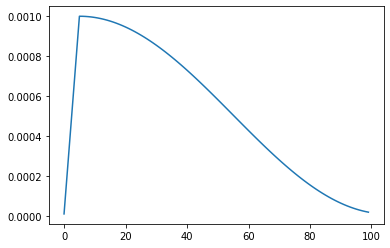

In [39]:
schedulerTest = get_scheduler(epochs=100, warmup_epochs=5, learning_rate=1e-3)
lr = []
for epoch in range(100):
    lr.append(schedulerTest.get_lr())
    schedulerTest.step()
plt.plot(lr)
plt.show()


In [45]:
Model = ViT(
    in_c=3,
    num_classes=10,
    img_size=32,
    patch=8,
    dropout=0.5,
    attn_dropout=0.1,
    num_layers=7,
    hidden=384,
    head=12,
    mlp_hidden=384,
    is_cls_token=True,
)
paddle.summary(Model, (1, 3, 32, 32))


-------------------------------------------------------------------------------------
      Layer (type)            Input Shape          Output Shape         Param #    
        Patches-6           [[1, 3, 32, 32]]       [1, 64, 48]             0       
        Linear-33            [[1, 64, 48]]         [1, 64, 384]         18,816     
      LayerNorm-16           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-34            [[1, 65, 384]]       [1, 65, 1152]         443,520    
       Dropout-23          [[1, 12, 65, 65]]     [1, 12, 65, 65]           0       
        Linear-35            [[1, 65, 384]]        [1, 65, 384]         147,840    
       Dropout-22            [[1, 65, 384]]        [1, 65, 384]            0       
MultiHeadSelfAttention-8     [[1, 65, 384]]        [1, 65, 384]            0       
      LayerNorm-17           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-36            [[1, 65, 384]]        [1, 65, 384]         14

{'total_params': 6243466, 'trainable_params': 6243466}

In [46]:
EPOCHS = 20
BATCH_SIZE = 128
NUM_CLASSES = 100
WARMUP_EPOCHS = 5
LR = 1e-3

scheduler = get_scheduler(
    epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, learning_rate=LR
)
optim = paddle.optimizer.Adam(
    learning_rate=scheduler, parameters=Model.parameters(), weight_decay=5e-5
)
criterion = LabelSmoothingCrossEntropyLoss(NUM_CLASSES, smoothing=0.1)

train_loader = DataLoader(
    cifar100_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=False,
)
test_loader = DataLoader(
    cifar100_test,
    batch_size=BATCH_SIZE * 16,
    shuffle=False,
    num_workers=0,
    drop_last=False,
)


In [47]:
def train_epoch(model, epoch, interval=1):
    acc_num = 0
    total_samples = 0
    nb = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(
        pbar, total=nb, colour="red", disable=((epoch + 1) % interval != 0)
    )
    pbar.set_description(f"EPOCH: {epoch:3d}")
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        loss = criterion(predicts, y_data)
        loss_item = loss.item()
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        total_acc = acc_num / total_samples
        current_lr = optim.get_lr()
        loss.backward()
        pbar.set_postfix(
            train_loss=f"{loss_item:5f}",
            train_acc=f"{total_acc:5f}",
            train_lr=f"{current_lr:5f}",
        )
        optim.step()
        optim.clear_grad()
    scheduler.step()


In [48]:
@paddle.no_grad()
def validation(model, epoch, interval=20):
    model.eval()
    acc_num = 0
    total_samples = 0
    nb = len(test_loader)
    pbar = enumerate(test_loader)
    pbar = tqdm(
        pbar, total=nb, colour="green", disable=((epoch + 1) % interval != 0)
    )
    pbar.set_description(f"EVAL")
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = model(x_data)
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        batch_acc = paddle.metric.accuracy(predicts, y_data.unsqueeze(1)).item()
        total_acc = acc_num / total_samples
        pbar.set_postfix(
            eval_batch_acc=f"{batch_acc:4f}", total_acc=f"{total_acc:4f}"
        )


In [49]:
start = time.time()
for epoch in range(EPOCHS):
    train_epoch(Model, epoch)
    validation(Model, epoch)
    if (epoch + 1) % 10 == 0:
        paddle.save(Model.state_dict(), str(epoch + 1) + ".pdparams")
paddle.save(Model.state_dict(), "finished.pdparams")
end = time.time()
print("Training Cost ", (end - start) / 60, "minutes")


EVAL: 100%|█████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s, eval_batch_acc=0.739491, total_acc=0.736600]

Training Cost  14.609939368565877 minutes


In [50]:
state_dict = paddle.load("finished.pdparams")
Model.set_state_dict(state_dict)
Model.eval()
top1_num = 0
top5_num = 0
total_samples = 0
nb = len(test_loader)
pbar = enumerate(test_loader)
pbar = tqdm(pbar, total=nb, colour="green")
pbar.set_description(f"EVAL")
with paddle.no_grad():
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        predicts = Model(x_data)
        total_samples += y_data.shape[0]
        top1_num += (
            paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=1).item()
            * y_data.shape[0]
        )
        top5_num += (
            paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=5).item()
            * y_data.shape[0]
        )
        TOP1 = top1_num / total_samples
        TOP5 = top5_num / total_samples
        pbar.set_postfix(TOP1=f"{TOP1:4f}", TOP5=f"{TOP5:4f}")


EVAL: 100%|████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.56it/s, TOP1=0.736600, TOP5=0.983400]


In [56]:
Model.eval()
data = cifar100_test[np.random.randint(0, len(cifar100_test))]
pred = Model(paddle.to_tensor(data[0]).unsqueeze(0)).argmax(-1).item()
print("预测结果为:", pred, "标签为:", data[1].item())

预测结果为: 7 标签为: 7


In [58]:
! wget https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar

--2025-03-06 20:06:45--  https://paddle-imagenet-models-name.bj.bcebos.com/data/mnist.tar
Resolving paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)... 36.110.192.178
Connecting to paddle-imagenet-models-name.bj.bcebos.com (paddle-imagenet-models-name.bj.bcebos.com)|36.110.192.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104252416 (99M) [application/x-tar]
Saving to: 'mnist.tar'

     0K .......... .......... .......... .......... ..........  0% 1.03M 96s
    50K .......... .......... .......... .......... ..........  0% 2.12M 71s
   100K .......... .......... .......... .......... ..........  0% 3.32M 58s
   150K .......... .......... .......... .......... ..........  0% 4.95M 48s
   200K .......... .......... .......... .......... ..........  0% 4.72M 43s
   250K .......... .......... .......... .......... ..........  0% 7.12M 38s
   300K .......... .......... .......... .......... ..........  0% 7.44M 34s
   350K 

In [59]:
! tar -xf mnist.tar

In [2]:
import os

In [3]:
path = 'Z:\BaiduNetdiskDownload\medicinalherb'

In [4]:
dirs = os.listdir(path)

In [5]:
for root,dirs,files in os.walk(path):
    print(f'当前路径: {root}')
    print(f'子文件夹列表: {dirs}')
    break

当前路径: Z:\BaiduNetdiskDownload\medicinalherb
子文件夹列表: ['test', 'train']


In [2]:
path = r'Z:\BaiduNetdiskDownload\medicinalherb\test\imgs'

In [3]:
os.listdir(path)

['aiye',
 'ajiao',
 'baibiandou',
 'baifan',
 'baihuasheshecao',
 'baikou',
 'baimaogen',
 'baishao',
 'baizhu',
 'bajitian']

In [4]:
total_pic_list = []

In [5]:
for pic_dir in os.listdir(path):
    pic_list = os.listdir(path+ "\\" +pic_dir)
    for pic_name in pic_list:
        total_pic_list.append(pic_name)

In [6]:
shuffle_total_pic_list = np.random.permutation(total_pic_list)

In [7]:
shuffle_total_pic_list[0]

'baishao_0491.jpg'

In [8]:
# 原始数据
herb_list = [
    'aiye',
    'ajiao',
    'baibiandou',
    'baifan',
    'baihuasheshecao',
    'baikou',
    'baimaogen',
    'baishao',
    'baizhu',
    'bajitian'
]

# 创建字典映射（保留原始顺序）
herb_to_id = {name: idx for idx, name in enumerate(herb_list)}

# 输出结果验证
print("草药名称到整数的映射：")
for name, idx in herb_to_id.items():
    print(f"{name}: {idx}")

# 反向映射字典（如果需要）
id_to_herb = {idx: name for name, idx in herb_to_id.items()}

草药名称到整数的映射：
aiye: 0
ajiao: 1
baibiandou: 2
baifan: 3
baihuasheshecao: 4
baikou: 5
baimaogen: 6
baishao: 7
baizhu: 8
bajitian: 9


In [17]:
with open(path+"class.txt",'w') as f:
    for name,idx in id_to_herb.items():
        f.write(f'{idx}\t{name}\n')
        print(f'{idx}\t{name}\n')

aiye	0

ajiao	1

baibiandou	2

baifan	3

baihuasheshecao	4

baikou	5

baimaogen	6

baishao	7

baizhu	8

bajitian	9



In [9]:
def get_key(value):
    return [k for k,v in id_to_herb.items() if v == value][0]

In [10]:
id_to_herb

{0: 'aiye',
 1: 'ajiao',
 2: 'baibiandou',
 3: 'baifan',
 4: 'baihuasheshecao',
 5: 'baikou',
 6: 'baimaogen',
 7: 'baishao',
 8: 'baizhu',
 9: 'bajitian'}

In [11]:
get_key('aiye')

0

In [12]:
with open(path+"\\"+'label.txt','w',encoding='utf-8') as f:
    for pic_name in shuffle_total_pic_list:
        print(f"imgs/{pic_name}\t{pic_name.split('_')[0]}\n")
        f.write(f"imgs/{pic_name.split('_')[0]}/{pic_name}\t{get_key(pic_name.split('_')[0])}\n")

imgs/baishao_0491.jpg	baishao

imgs/baishao_1303.jpg	baishao

imgs/baishao_0421.jpg	baishao

imgs/ajiao_0272.jpg	ajiao

imgs/ajiao_0121.jpg	ajiao

imgs/baifan_1620.jpg	baifan

imgs/baibiandou_1254.jpg	baibiandou

imgs/baimaogen_1372.jpg	baimaogen

imgs/baibiandou_0257.jpg	baibiandou

imgs/baibiandou_0112.jpg	baibiandou

imgs/baimaogen_0712.jpg	baimaogen

imgs/baibiandou_0304.jpg	baibiandou

imgs/baishao_0766.jpg	baishao

imgs/baikou_1240.jpg	baikou

imgs/baikou_0649.jpg	baikou

imgs/ajiao_0344.jpg	ajiao

imgs/baibiandou_1038.jpg	baibiandou

imgs/baihuasheshecao_1065.jpg	baihuasheshecao

imgs/baifan_1489.jpg	baifan

imgs/ajiao_1431.jpg	ajiao

imgs/ajiao_0880.jpg	ajiao

imgs/baikou_0202.jpg	baikou

imgs/bajitian_1121.jpg	bajitian

imgs/baimaogen_1030.jpg	baimaogen

imgs/ajiao_0452.jpg	ajiao

imgs/baishao_0649.jpg	baishao

imgs/ajiao_0421.jpg	ajiao

imgs/baibiandou_1015.jpg	baibiandou

imgs/bajitian_1567.jpg	bajitian

imgs/baihuasheshecao_1025.jpg	baihuasheshecao

imgs/baizhu_1401.jpg	bai

In [88]:
pwd

'C:\\Users\\86173\\Desktop\\WZ_ScikitLearn'

In [78]:
import os
import cv2
import numpy as np
from paddle.io import Dataset
from paddle.vision.transforms import Normalize


class MyDataset(Dataset):
    """
    步骤一：继承 paddle.io.Dataset 类
    """

    def __init__(self, data_dir, label_path, transform=None):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中
        """
        super().__init__()
        self.data_list = []
        with open(label_path, encoding="utf-8") as f:
            for line in f.readlines():
                image_path, label = line.strip().split("\t")
                image_path = os.path.join(data_dir, image_path)
                self.data_list.append([image_path, label])
        # 传入定义好的数据处理方法，作为自定义数据集类的一个属性
        self.transform = transform

    def __getitem__(self, index):
        """
        步骤三：实现 __getitem__ 函数，定义指定 index 时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        # 根据索引，从列表中取出一个图像
        # print(self.data_list)
        image_path, label = self.data_list[index]
        # 读取灰度图
        # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        # 读取彩色图
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)
        image = np.transpose(image, (2, 0, 1))           # 将 HWC 转换为 CHW
        # 飞桨训练时内部数据格式默认为float32，将图像数据格式转换为 float32
        image = image.astype("float32")
        # 应用数据处理方法到图像上
        if self.transform is not None:
            image = self.transform(image)
        # CrossEntropyLoss要求label格式为int，将Label格式转换为 int
        # label = int(label)
        # 返回图像和对应标签
        return image, label

    def __len__(self):
        """
        步骤四：实现 __len__ 函数，返回数据集的样本总数
        """
        return len(self.data_list)



# 定义图像归一化处理方法，这里的CHW指图像格式需为 [C通道数，H图像高度，W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")
# 打印数据集样本数
train_custom_dataset = MyDataset(
    r"Z:/BaiduNetdiskDownload/medicinalherb/train", r"Z:/BaiduNetdiskDownload/medicinalherb/train/label.txt", transform
)
test_custom_dataset = MyDataset(r"Z:/BaiduNetdiskDownload/medicinalherb/test", r"Z:/BaiduNetdiskDownload/medicinalherb/test/label.txt", transform)
print(
    "train_custom_dataset images: ",
    len(train_custom_dataset),
    "test_custom_dataset images: ",
    len(test_custom_dataset),
)


train_custom_dataset images:  15689 test_custom_dataset images:  597


In [106]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(
    train_custom_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=1,
    drop_last=True,
)

# 调用 DataLoader 迭代读取数据
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print("batch_id: {}, 训练数据shape: {}, 标签数据shape: {}".format(batch_id, np.array(images).shape, np.array(labels).shape))
    break

batch_id: 0, 训练数据shape: (64, 3, 32, 32), 标签数据shape: (64,)


[2025-03-07 13:47:51,746] [ WARNING] image.py:705 - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8039216].


shape of image:  (32, 32, 3)


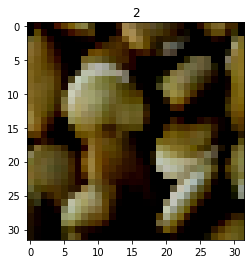

In [72]:
for data in train_custom_dataset:
    image, label = data
    image = np.transpose(image, (1,2,0))
    print("shape of image: ", image.shape)
    plt.title(str(label))
    plt.imshow(img)
    break

In [76]:
def anti_normalize(image):
    image = paddle.to_tensor(image)
    t_mean = paddle.to_tensor(mean).reshape([3, 1, 1]).expand([3, 32, 32])
    t_std = paddle.to_tensor(std).reshape([3, 1, 1]).expand([3, 32, 32])
    return (image * t_std + t_mean).transpose([1, 2, 0])


def plot_num_images(num, data):
    if num < 1:
        print("INFO:The number of input pictures must be greater than zero!")
    else:
        choose_list = []
        for i in range(num):
            choose_n = np.random.randint(len(data))
            choose_list.append(choose_n)
        fig = plt.gcf()
        fig.set_size_inches(10, 10)
        for i in range(num):
            ax_img = plt.subplot(
                math.ceil(num / int(math.sqrt(num))), int(math.sqrt(num)), i + 1
            )
            single_data = data[choose_list[i]]
            plt_img = anti_normalize(single_data[0])
            ax_img.imshow(plt_img, cmap="binary")
            ax_img.set_title("label:" + str(single_data[1]), fontsize=10)
            ax_img.axis("off")
        plt.show()


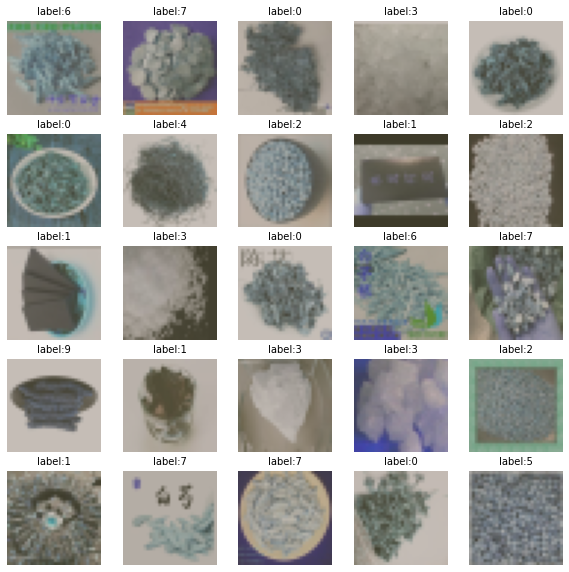

In [79]:
plot_num_images(25, train_custom_dataset)

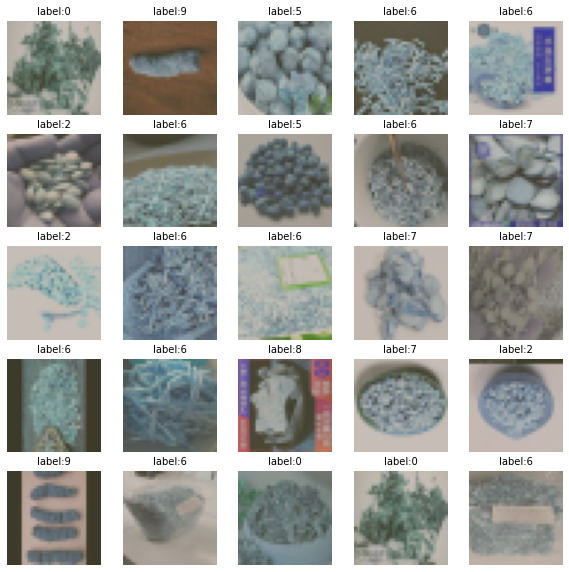

In [80]:
plot_num_images(25, test_custom_dataset)

In [81]:
class Patches(paddle.nn.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def forward(self, images):
        patches = F.unfold(images, self.patch_size, self.patch_size)
        return patches.transpose([0, 2, 1])


C:\Users\86173\AppData\Local\Programs\Python\Python39\lib\site-packages\paddle\tensor\creation.py:943: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach(), rather than paddle.to_tensor(sourceTensor).
  warnings.warn(


Image size: 32 X 32
Patch size: 8 X 8
Patches per image: 16
Elements per patch: 192


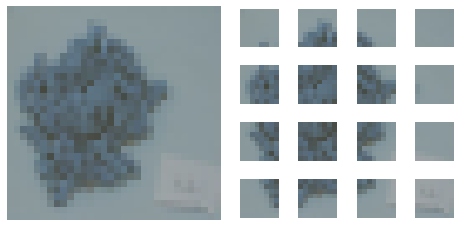

In [83]:
image_size = 32
patch_size = 8

image = anti_normalize(
    paddle.to_tensor(test_custom_dataset[np.random.choice(len(test_custom_dataset))][0])
)
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(4, 8, wspace=0.5, figure=fig)
plt.subplot(grid[:4, :4])
plt.imshow(image)
plt.axis("off")

patches = Patches(patch_size)(image.transpose([2, 0, 1]).unsqueeze(0))

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

for i, patch in enumerate(patches[0]):
    plt.subplot(grid[i // 4, i % 4 + 4])
    patch_img = patch.reshape([3, patch_size, patch_size]).transpose([1, 2, 0])
    plt.imshow(patch_img)
    plt.axis("off")


In [84]:
class Mlp(nn.Layer):
    def __init__(self, feats, mlp_hidden, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(feats, mlp_hidden)
        self.fc2 = nn.Linear(mlp_hidden, feats)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)

        return x


In [85]:
class MultiHeadSelfAttention(nn.Layer):
    def __init__(self, feats, head=8, dropout=0.0, attn_dropout=0.0):
        super(MultiHeadSelfAttention, self).__init__()
        self.head = head
        self.feats = feats
        self.sqrt_d = self.feats**0.5
        self.qkv = nn.Linear(feats, feats * 3)
        self.out = nn.Linear(feats, feats)
        self.dropout = nn.Dropout(dropout)
        self.attn_dropout = nn.Dropout(attn_dropout)

    def transpose_multi_head(self, x):
        new_shape = x.shape[:-1] + [self.head, self.feats // self.head]
        x = x.reshape(new_shape)
        x = x.transpose([0, 2, 1, 3])
        return x

    def forward(self, x):
        b, n, f = x.shape
        qkv = self.qkv(x).chunk(3, -1)
        q, k, v = map(self.transpose_multi_head, qkv)
        attn = F.softmax(
            paddle.einsum("bhif, bhjf->bhij", q, k) / self.sqrt_d, axis=-1
        )
        attn = self.attn_dropout(attn)
        attn = paddle.einsum("bhij, bhjf->bihf", attn, v)
        out = self.dropout(self.out(attn.flatten(2)))
        return out


In [86]:
class TransformerEncoder(nn.Layer):
    def __init__(
        self, feats, mlp_hidden, head=8, dropout=0.0, attn_dropout=0.0
    ):
        super(TransformerEncoder, self).__init__()
        self.layer1 = nn.LayerNorm(feats)
        self.msa = MultiHeadSelfAttention(
            feats, head=head, dropout=dropout, attn_dropout=attn_dropout
        )
        self.layer2 = nn.LayerNorm(feats)
        self.mlp = Mlp(feats, mlp_hidden)

    def forward(self, x):
        out = self.msa(self.layer1(x)) + x
        out = self.mlp(self.layer2(out)) + out
        return out


In [87]:
class ViT(nn.Layer):
    def __init__(
        self,
        in_c=3,
        num_classes=10,
        img_size=32,
        patch=8,
        dropout=0.0,
        attn_dropout=0.0,
        num_layers=7,
        hidden=384,
        mlp_hidden=384 * 4,
        head=8,
        is_cls_token=True,
    ):
        super(ViT, self).__init__()
        self.patch = patch
        self.is_cls_token = is_cls_token
        self.patch_size = img_size // self.patch
        self.patches = Patches(self.patch_size)
        f = (img_size // self.patch) ** 2 * 3
        num_tokens = (
            (self.patch**2) + 1 if self.is_cls_token else (self.patch**2)
        )

        self.emb = nn.Linear(f, hidden)
        self.cls_token = (
            paddle.create_parameter(
                shape=[1, 1, hidden],
                dtype="float32",
                default_initializer=nn.initializer.Assign(
                    paddle.randn([1, 1, hidden])
                ),
            )
            if is_cls_token
            else None
        )

        self.pos_embedding = paddle.create_parameter(
            shape=[1, num_tokens, hidden],
            dtype="float32",
            default_initializer=nn.initializer.Assign(
                paddle.randn([1, num_tokens, hidden])
            ),
        )

        encoder_list = [
            TransformerEncoder(
                hidden,
                mlp_hidden=mlp_hidden,
                dropout=dropout,
                attn_dropout=attn_dropout,
                head=head,
            )
            for _ in range(num_layers)
        ]
        self.encoder = nn.Sequential(*encoder_list)
        self.fc = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, num_classes),  # for cls_token
        )

    def forward(self, x):
        out = self.patches(x)
        out = self.emb(out)
        if self.is_cls_token:
            out = paddle.concat(
                [self.cls_token.tile([out.shape[0], 1, 1]), out], axis=1
            )
        out = out + self.pos_embedding
        out = self.encoder(out)
        if self.is_cls_token:
            out = out[:, 0]
        else:
            out = out.mean(1)
        out = self.fc(out)
        return out


In [88]:
class LabelSmoothingCrossEntropyLoss(nn.Layer):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = F.log_softmax(pred, axis=self.dim)
        with paddle.no_grad():
            true_dist = paddle.ones_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.put_along_axis_(target.unsqueeze(1), self.confidence, 1)
        return paddle.mean(paddle.sum(-true_dist * pred, axis=self.dim))


def get_scheduler(epochs, warmup_epochs, learning_rate):
    base_scheduler = lrScheduler.CosineAnnealingDecay(
        learning_rate=learning_rate, T_max=epochs, eta_min=1e-5, verbose=False
    )
    scheduler = lrScheduler.LinearWarmup(
        base_scheduler,
        warmup_epochs,
        1e-5,
        learning_rate,
        last_epoch=-1,
        verbose=False,
    )
    return scheduler


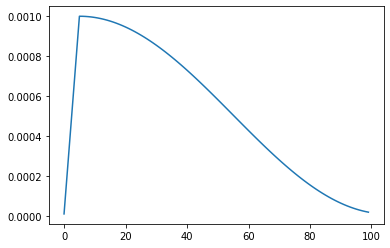

In [89]:
schedulerTest = get_scheduler(epochs=100, warmup_epochs=5, learning_rate=1e-3)
lr = []
for epoch in range(100):
    lr.append(schedulerTest.get_lr())
    schedulerTest.step()
plt.plot(lr)
plt.show()


In [90]:
Model = ViT(
    in_c=3,
    num_classes=10,
    img_size=32,
    patch=8,
    dropout=0.5,
    attn_dropout=0.1,
    num_layers=7,
    hidden=384,
    head=12,
    mlp_hidden=384,
    is_cls_token=True,
)
paddle.summary(Model, (1, 3, 32, 32))


------------------------------------------------------------------------------------
      Layer (type)           Input Shape          Output Shape         Param #    
       Patches-3           [[1, 3, 32, 32]]       [1, 64, 48]             0       
        Linear-1            [[1, 64, 48]]         [1, 64, 384]         18,816     
      LayerNorm-1           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-2            [[1, 65, 384]]       [1, 65, 1152]         443,520    
       Dropout-2          [[1, 12, 65, 65]]     [1, 12, 65, 65]           0       
        Linear-3            [[1, 65, 384]]        [1, 65, 384]         147,840    
       Dropout-1            [[1, 65, 384]]        [1, 65, 384]            0       
MultiHeadSelfAttention-1    [[1, 65, 384]]        [1, 65, 384]            0       
      LayerNorm-2           [[1, 65, 384]]        [1, 65, 384]           768      
        Linear-4            [[1, 65, 384]]        [1, 65, 384]         147,840    
  

{'total_params': 6243466, 'trainable_params': 6243466}

In [98]:
cifar100_train

In [99]:
train_custom_dataset

In [94]:
EPOCHS = 20
BATCH_SIZE = 128
NUM_CLASSES = 100
WARMUP_EPOCHS = 5
LR = 1e-3

scheduler = get_scheduler(
    epochs=EPOCHS, warmup_epochs=WARMUP_EPOCHS, learning_rate=LR
)
optim = paddle.optimizer.Adam(
    learning_rate=scheduler, parameters=Model.parameters(), weight_decay=5e-5
)
criterion = LabelSmoothingCrossEntropyLoss(NUM_CLASSES, smoothing=0.1)

train_loader = DataLoader(
    train_custom_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    drop_last=False,
)
test_loader = DataLoader(
    test_custom_dataset,
    batch_size=BATCH_SIZE * 16,
    shuffle=False,
    num_workers=0,
    drop_last=False,
)


In [128]:
def train_epoch(model, epoch, interval=1):
    acc_num = 0
    total_samples = 0
    nb = len(train_loader)
    pbar = enumerate(train_loader)
    pbar = tqdm(
        pbar, total=nb, colour="red", disable=((epoch + 1) % interval != 0)
    )
    pbar.set_description(f"EPOCH: {epoch:3d}")
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        # 将 y_data 转换为 int 类型
        y_data = np.array(y_data, dtype='int64')  # 将 y_data 转换为 int64 数组
        y_data = paddle.to_tensor(y_data)  # 将 y_data 转换为 PaddlePaddle 张量

        predicts = model(x_data)
        loss = criterion(predicts, y_data)
        loss_item = loss.item()
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        total_acc = acc_num / total_samples
        current_lr = optim.get_lr()
        loss.backward()
        pbar.set_postfix(
            train_loss=f"{loss_item:5f}",
            train_acc=f"{total_acc:5f}",
            train_lr=f"{current_lr:5f}",
        )
        optim.step()
        optim.clear_grad()
    scheduler.step()


In [129]:
@paddle.no_grad()
def validation(model, epoch, interval=20):
    model.eval()
    acc_num = 0
    total_samples = 0
    nb = len(test_loader)
    pbar = enumerate(test_loader)
    pbar = tqdm(
        pbar, total=nb, colour="green", disable=((epoch + 1) % interval != 0)
    )
    pbar.set_description(f"EVAL")
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        # 将 y_data 转换为 int 类型
        y_data = np.array(y_data, dtype='int64')  # 将 y_data 转换为 int64 数组
        y_data = paddle.to_tensor(y_data)  # 将 y_data 转换为 PaddlePaddle 张量
        # y_data = paddle.to_tensor(data[1])  # 将 y_data 转换为 PaddlePaddle 张量
        predicts = model(x_data)
        acc_num += paddle.sum(predicts.argmax(1) == y_data).item()
        total_samples += y_data.shape[0]
        batch_acc = paddle.metric.accuracy(predicts, y_data.unsqueeze(1)).item()
        total_acc = acc_num / total_samples
        pbar.set_postfix(
            eval_batch_acc=f"{batch_acc:4f}", total_acc=f"{total_acc:4f}"
        )


In [130]:
start = time.time()
for epoch in range(EPOCHS):
    train_epoch(Model, epoch)
    validation(Model, epoch)
    if (epoch + 1) % 10 == 0:
        paddle.save(Model.state_dict(), str(epoch + 1) + ".pdparams")
paddle.save(Model.state_dict(), "finished.pdparams")
end = time.time()
print("Training Cost ", (end - start) / 60, "minutes")


EVAL: 100%|█████████████████████████████████| 1/1 [00:00<00:00,  1.12it/s, eval_batch_acc=0.879397, total_acc=0.879397]

Training Cost  9.345590130488079 minutes


In [132]:
state_dict = paddle.load("finished.pdparams")
Model.set_state_dict(state_dict)
Model.eval()
top1_num = 0
top5_num = 0
total_samples = 0
nb = len(test_loader)
pbar = enumerate(test_loader)
pbar = tqdm(pbar, total=nb, colour="green")
pbar.set_description(f"EVAL")
with paddle.no_grad():
    for _, (_, data) in enumerate(pbar):
        x_data = data[0]
        y_data = data[1]
        y_data = np.array(y_data, dtype='int64')  # 将 y_data 转换为 int64 数组
        y_data = paddle.to_tensor(y_data)  # 将 y_data 转换为 PaddlePaddle 张量
        predicts = Model(x_data)
        total_samples += y_data.shape[0]
        top1_num += (
            paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=1).item()
            * y_data.shape[0]
        )
        top5_num += (
            paddle.metric.accuracy(predicts, y_data.unsqueeze(1), k=5).item()
            * y_data.shape[0]
        )
        TOP1 = top1_num / total_samples
        TOP5 = top5_num / total_samples
        pbar.set_postfix(TOP1=f"{TOP1:4f}", TOP5=f"{TOP5:4f}")


EVAL: 100%|████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.23s/it, TOP1=0.879397, TOP5=0.984925]


In [134]:
Model.eval()
data = test_custom_dataset[np.random.randint(0, len(test_custom_dataset))]
pred = Model(paddle.to_tensor(data[0]).unsqueeze(0)).argmax(-1).item()
y_data = data[1]
y_data = np.array(y_data, dtype='int64')  # 将 y_data 转换为 int64 数组
y_data = paddle.to_tensor(y_data)  # 将 y_data 转换为 PaddlePaddle 张量
print("预测结果为:", pred, "标签为:", y_data.item())

预测结果为: 1 标签为: 1


In [136]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score

def evaluate_model(model, data_loader):
    # 初始化变量
    all_preds = []
    all_labels = []

    # 将模型设置为评估模式
    model.eval()

    # 遍历数据加载器
    for data in data_loader:
        x_data = data[0]
        y_data = data[1]

        # 确保 y_data 是数值类型
        if isinstance(y_data, (list, np.ndarray)):
            y_data = np.array(y_data, dtype='int64')  # 将 y_data 转换为 int64 数组

        # 将数据转换为 PaddlePaddle 张量
        x_data = paddle.to_tensor(x_data)
        y_data = paddle.to_tensor(y_data)

        # 模型预测
        preds = model(x_data)
        preds = preds.argmax(axis=1).numpy()  # 获取预测类别
        labels = y_data.numpy()  # 获取真实标签

        # 保存预测结果和真实标签
        all_preds.extend(preds)
        all_labels.extend(labels)

    # 计算指标
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')  # 使用 macro 平均
    recall = recall_score(all_labels, all_preds, average='macro')  # 使用 macro 平均
    f2 = fbeta_score(all_labels, all_preds, beta=2, average='macro')  # 使用 macro 平均

    # 打印结果
    print(f"准确率 (Accuracy): {accuracy:.4f}")
    print(f"精确率 (Precision): {precision:.4f}")
    print(f"召回率 (Recall): {recall:.4f}")
    print(f"F2 分数 (F2 Score): {f2:.4f}")

# 调用函数计算指标
evaluate_model(Model, test_loader)

准确率 (Accuracy): 0.8794
精确率 (Precision): 0.8776
召回率 (Recall): 0.8809
F2 分数 (F2 Score): 0.8799


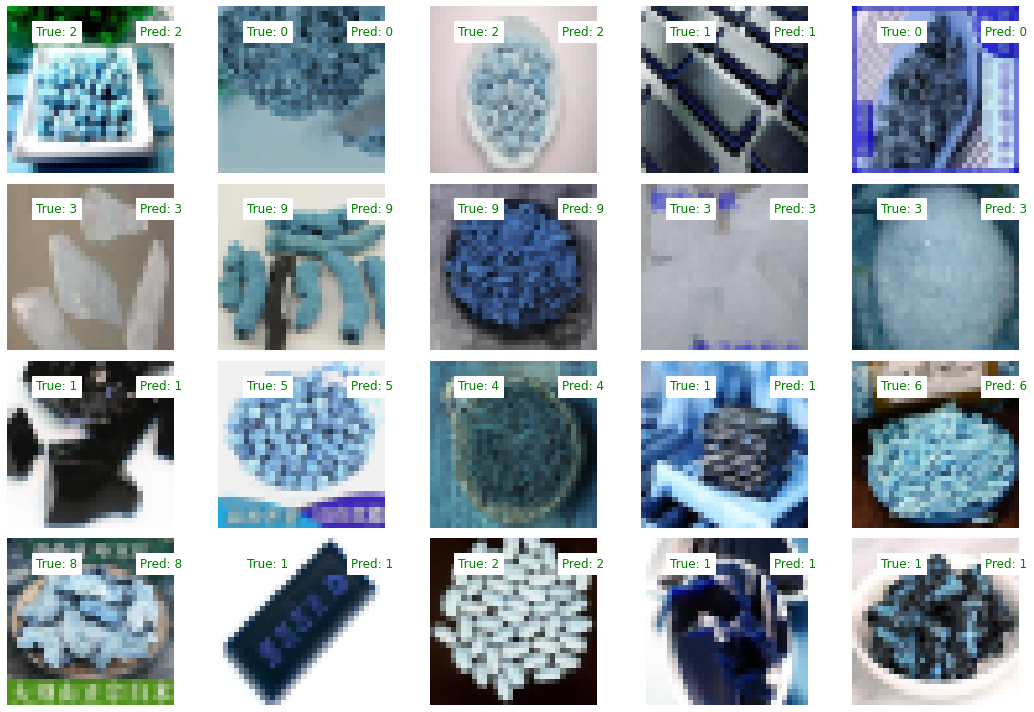

In [180]:
import paddle
import numpy as np
import matplotlib.pyplot as plt
from paddle.io import DataLoader
from paddle.vision.transforms import Normalize
import cv2

# 定义反归一化函数
def anti_normalize(image, mean=[127.5], std=[127.5]):
    image = paddle.to_tensor(image)
    t_mean = paddle.to_tensor(mean).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    t_std = paddle.to_tensor(std).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    return (image * t_std + t_mean).transpose([1, 2, 0]).numpy().astype('uint8')

# 定义可视化函数
def visualize_predictions(model, dataset, num_images=20):
    # 随机选择 20 张图片
    indices = np.random.choice(len(dataset), num_images, replace=False)
    
    # 设置画布
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(indices):
        # 获取数据和标签
        image, true_label = dataset[idx]
        
        # 确保图像维度正确
        if image.shape[0] != 3:  # 如果不是 3 通道，转换为 3 通道
            image = np.transpose(image, (1, 2, 0))  # 将 CHW 转换为 HWC
            # image = np.transpose(image, (2, 0, 1))  # 将 HWC 转换回 CHW
        
        # 将数据转换为 PaddlePaddle 张量
        image_tensor = paddle.to_tensor(image).unsqueeze(0)
        # print(image_tensor)
        # 模型预测
        model.eval()
        pred = model(image_tensor).argmax(-1).item()
        
        # 反归一化图像
        image = anti_normalize(image)
        
        # 绘制图像
        plt.subplot(4, 5, i + 1)
        plt.imshow(image)
        plt.axis('off')
        
        # 显示实际标签和预测标签
        plt.text(5, 5, f"True: {true_label}", color='green', fontsize=12, backgroundcolor='white')
        if pred == int(true_label):
            plt.text(25, 5, f"Pred: {pred}", color='green', fontsize=12, backgroundcolor='white')
        else:
            plt.text(25, 5, f"Pred: {pred}", color='red', fontsize=12, backgroundcolor='white')
    
    plt.tight_layout()
    plt.show()

# 调用可视化函数
visualize_predictions(Model, test_custom_dataset, num_images=20)

In [166]:
img_path = r'Z:\BaiduNetdiskDownload\medicinalherb\test\imgs\aiye'

In [167]:
img_path_list = os.listdir(img_path)

In [168]:
img_path_list[0]

'aiye_0054.jpg'

In [169]:
img = cv2.imread(img_path+"\\"+img_path_list[0])

cv2.imshow('img',img)
cv2.waitKey()
cv2.destroyAllWindows()

In [174]:
import paddle
import numpy as np
import cv2
from paddle.vision.transforms import Normalize

# 定义 Normalize 变换
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")

# 定义反归一化函数
def anti_normalize(image, mean=[127.5], std=[127.5]):
    image = paddle.to_tensor(image).astype('float32')  # 将 image 转换为 float32
    t_mean = paddle.to_tensor(mean).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    t_std = paddle.to_tensor(std).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    return (image * t_std + t_mean).transpose([1, 2, 0]).numpy().astype('uint8')

# 定义额外处理函数
def additional_transform(image):
    """
    在 Normalize 之后进一步处理图像
    """
    # 示例：将图像转换为灰度图
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# 读取图片
image_path = r'Z:\BaiduNetdiskDownload\medicinalherb\test\imgs\aiye\aiye_0054.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 读取彩色图片
image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)  # 调整大小为 32x32
image = np.transpose(image, (2, 0, 1))  # 将 HWC 转换为 CHW
image = image.astype('float32')  # 转换为 float32

# 应用 Normalize 变换
image = transform(image)

# 应用额外处理
image = additional_transform(image)

# 反归一化图像
image = anti_normalize(image)

# 显示图片
cv2.imshow('img', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [178]:
import paddle
import numpy as np
import cv2
from paddle.vision.transforms import Normalize

# 定义 Normalize 变换
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")

# 定义反归一化函数
def anti_normalize(image, mean=[127.5], std=[127.5]):
    image = paddle.to_tensor(image).astype('float32')  # 将 image 转换为 float32
    t_mean = paddle.to_tensor(mean).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    t_std = paddle.to_tensor(std).reshape([1, 1, 1]).expand([3, 32, 32])  # 调整为 3 通道
    return (image * t_std + t_mean).transpose([1, 2, 0]).numpy().astype('uint8')

# 定义额外处理函数
def additional_transform(image):
    """
    在 Normalize 之后进一步处理图像
    """
    # 示例：将图像转换为灰度图
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# 读取图片
image_path = r'Z:\BaiduNetdiskDownload\medicinalherb\test\imgs\aiye\aiye_0054.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 读取彩色图片
image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)  # 调整大小为 32x32
image = np.transpose(image, (2, 0, 1))  # 将 HWC 转换为 CHW
image = image.astype('float32')  # 转换为 float32

# 应用 Normalize 变换
image = transform(image)

# 应用额外处理
image = additional_transform(image)

# 反归一化图像
image = anti_normalize(image)

# 使用模型进行预测
Model.eval()  # 将模型设置为评估模式
image_tensor = paddle.to_tensor(image).unsqueeze(0).astype('float32')  # 确保输入为 float32

print(image_tensor.shape)
pred = Model(image_tensor).argmax(-1).item()  # 获取预测结果

# 获取实际标签（假设实际标签为 8）
true_label = 0

# 在图片上显示实际标签和预测标签
if pred == true_label:
    pred_color = (0, 255, 0)  # 预测正确，绿色
else:
    pred_color = (0, 0, 255)  # 预测错误，红色

# 在图片上添加文本
image = cv2.putText(image, f"True: {true_label}", (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)  # 实际标签（蓝色）
image = cv2.putText(image, f"Pred: {pred}", (25, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, pred_color, 1)  # 预测标签（绿色或红色）

# 显示图片
cv2.imshow('img', image)
cv2.waitKey()
cv2.destroyAllWindows()

# 打印预测结果
print(f"实际标签: {true_label}, 预测标签: {pred}")

[1, 32, 32, 3]


ValueError: (InvalidArgument) Input(Y) has error dim. Y'dims[0] must be equal to 512, but received Y'dims[0] is 48.
  [Hint: Expected y_dims[y_ndim - 2] == K, but received y_dims[y_ndim - 2]:48 != K:512.] (at C:/home/workspace/Paddle\paddle/phi/kernels/impl/matmul_kernel_impl.h:340)
  [operator < linear > error]

In [211]:
import paddle
import numpy as np
import cv2
from paddle.vision.transforms import Normalize

# 定义 Normalize 变换
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")

# 读取图片
image_path = r'Z:\BaiduNetdiskDownload\medicinalherb\train\imgs\aiye\aiye_0001.jpg'
image_orgin = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 读取彩色图片
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 读取彩色图片
image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)  # 调整大小为 32x32
image = np.transpose(image, (2, 0, 1))  # 将 HWC 转换为 CHW
image = image.astype('float32')  # 转换为 float32

# 应用 Normalize 变换
image = transform(image)

# 将图像转换为 PaddlePaddle 张量并添加 batch 维度
image_tensor = paddle.to_tensor(image).unsqueeze(0)  # 添加 batch 维度

# 打印张量形状
print(image_tensor.shape)  # 输出: [1, 3, 32, 32]
img = np.transpose(image,[1,2,0])
print(img.shape)

pred = Model(image_tensor).argmax(-1).item()  # 获取预测结果

# 获取实际标签（假设实际标签为 8）
true_label = 0

# 在图片上显示实际标签和预测标签
if pred == true_label:
    pred_color = (0, 255, 0)  # 预测正确，绿色
else:
    pred_color = (0, 0, 255)  # 预测错误，红色

# 在图片上添加文本
img = cv2.putText(image_orgin, f"True: {true_label}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)  # 实际标签（蓝色）
img = cv2.putText(image_orgin, f"Pred: {pred}", (150, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, pred_color, 1)  # 预测标签（绿色或红色）
# 创建可调整大小的窗口
cv2.namedWindow('img', cv2.WINDOW_NORMAL)  # 设置窗口为可调整大小

# 显示图片
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

# 打印预测结果
print(f"实际标签: {true_label}, 预测标签: {pred}")

[1, 3, 32, 32]
(32, 32, 3)
实际标签: 0, 预测标签: 0


In [226]:
import paddle
import numpy as np
import cv2
from paddle.vision.transforms import Normalize

# 定义模型结构（假设是一个简单的 CNN 模型）
class MyModel(paddle.nn.Layer):
    def __init__(self, num_classes=10):
        super(MyModel, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.fc = paddle.nn.Linear(in_features=32 * 8 * 8, out_features=num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = paddle.nn.functional.relu(x)
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1)
        x = self.fc(x)
        return x

# 定义 Normalize 变换
transform = Normalize(mean=[127.5], std=[127.5], data_format="CHW")

# 读取图片
image_path = r'Z:\BaiduNetdiskDownload\medicinalherb\train\imgs\aiye\aiye_0025.jpg'
image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # 读取彩色图片
image = cv2.resize(image, (32, 32), interpolation=cv2.INTER_AREA)  # 调整大小为 32x32
image = np.transpose(image, (2, 0, 1))  # 将 HWC 转换为 CHW
image = image.astype('float32')  # 转换为 float32

# 应用 Normalize 变换
image = transform(image)

# 将图像转换为 PaddlePaddle 张量并添加 batch 维度
image_tensor = paddle.to_tensor(image).unsqueeze(0)  # 添加 batch 维度

# 打印张量形状
print(image_tensor.shape)  # 输出: [1, 3, 32, 32]

# 加载模型权重
# model = MyModel(num_classes=10)  # 实例化模型
Model.set_state_dict(paddle.load('20.pdparams'))  # 加载模型权重
Model.eval()  # 将模型设置为评估模式

# 使用模型进行预测
pred = Model(image_tensor).argmax(-1).item()  # 获取预测结果

# 获取实际标签（假设实际标签为 5）
true_label = 0

# 反归一化图像
img = np.transpose(image, [1, 2, 0])  # 将 CHW 转换为 HWC
img = (img * 127.5 + 127.5).astype('uint8')  # 反归一化

# 在图片上显示实际标签和预测标签
if pred == true_label:
    pred_color = (0, 255, 0)  # 预测正确，绿色
else:
    pred_color = (0, 0, 255)  # 预测错误，红色

# 在图片上添加文本
img = cv2.putText(img, f"T: {true_label}", (0, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 0, 0), 1)  # 实际标签（蓝色）
img = cv2.putText(img, f"P: {pred}", (15, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, pred_color, 1)  # 预测标签（绿色或红色）

# 创建可调整大小的窗口
cv2.namedWindow('img', cv2.WINDOW_NORMAL)  # 设置窗口为可调整大小

# 显示图片
cv2.imshow('img', img)
cv2.waitKey()
cv2.destroyAllWindows()

# 打印预测结果
print(f"实际标签: {true_label}, 预测标签: {pred}")

[1, 3, 32, 32]
实际标签: 0, 预测标签: 0
